In [1]:
# this notebook builds upon "2023-04-18 combine tdr passes one eye pass.ipynb". Instead of interpolating for just one 
# eye pass, this notebook recursively loops through each tdr dataset and makes one continuous tdr dataset!
# kinda pain in the butt, and it's fragile code (a lot of things need to go right), but this would be a very helpful dataset!

In [1]:
# import...
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
os.chdir("/Users/etmu9498/research/code/scripts-winter2023")
import helper_fns_winter2023 as helper_fns

In [12]:
# load combined crl and flight level dataset
os.chdir("/Users/etmu9498/research/data/crl-all-data-processed/2021")

date = '0929'
if date == '0926':
    crlname = 'P3_20210926H1_processed.nc'
    tdrname = "tdr-sam-09-26-eye-"
elif date == '0927':
    crlname = 'P3_20210927H1_processed.nc'
    tdrname = "tdr-sam-09-27-eye-"
elif date == '0929':
    crlname = 'P3_20210929H2_processed.nc'
    tdrname = "tdr-sam-09-29-eye-"

crl_data = xr.open_dataset(crlname)

# crl_data

In [13]:
# step 1: find max radial distances for each tc center (center_dist ~ 0 km) for crl data
# this will allow us to center the TDR data and combine it!
# do this even before loading tdr data

dists = crl_data.center_dist.values
dists_len = len(dists)

# find radial distance mins
dist_mins = find_peaks(-dists, height=-10, distance=100)[0] # must be 10 km from center, 100 points


###### 
## new idea: a better way to find crl distance peaks!
## for each eye pass / distance center, use find_peaks to find distance peaks to the left and right of the point
## take the closest distance peaks (as long as they meet height requirements and aren't past the next tc center!)
## these are the eye limits for this case!
######

# for each center point, search radially outward for the furthest distance! in both directions
# the number of max points = 2* number of min points
dist_maxs = []
for distcount, distind in enumerate(dist_mins):
    # first, search to the left of the center minima:
    # iterate through all values to the left
    currenti = distind
    while True:
        # reached the beginning of the dataset: no peak, just give up lol
        # use 1, not 0, to not break the code by doing currenti-2 below
        if currenti == 1:
            dist_maxs.append(0)
            break
        else:
            # local peak found!
            if dists[currenti - 1] - dists[currenti] < 0 and dists[currenti - 2] - dists[currenti - 1] < 0:
                dist_maxs.append(currenti)
                break
            # no peak found
            else:
                currenti -= 1
                
    # next, iterate through all values to the right of the center min
    currenti = distind
    while True:
        # reached the end of the dataset: no peak, just give up lol
        if currenti == dists_len - 1:
            dist_maxs.append(currenti)
            break
        else:
            # local peak found!
            # check two cases to make sure this isn't a fluke
            if dists[currenti+1] - dists[currenti] < 0 and dists[currenti+2] - dists[currenti+1] < 0:
                dist_maxs.append(currenti)
                break
            # no peak found
            else:
                currenti += 1
                
print(dist_mins)
print(dist_maxs)

[ 791 3027 5299 8455]
[0, 1696, 2195, 3959, 4448, 6646, 8404, 8502]


In [14]:
# load the three processed (aka combined) tdr datasets for this case!
os.chdir("/Users/etmu9498/research/data/tdr-old/tdr-new")

tdr_data_list = []

if date == '0926':
    for i in range(1, 4):
        tdr_data_list.append(xr.open_dataset(tdrname + str(i) + ".nc"))
elif date == '0927':
    for i in range(2, 4):
        tdr_data_list.append(xr.open_dataset(tdrname + str(i) + ".nc"))
elif date == '0929':
    for i in range(1, 3):
        tdr_data_list.append(xr.open_dataset(tdrname + str(i) + ".nc"))

tdr_new_reflect_list = []
tdr_new_dist_list = []
# do this for each of the tdr datasets!
for tdri, tdr_data in enumerate(tdr_data_list):
    # step 2: correlate outer distance peaks with TDR data

    print('tdr dataset ' + str(tdri))
    
    # do this for one pass first: the first pass from 9/26!
    lim0 = dist_maxs[2*tdri]
    lim1 = dist_maxs[2*tdri+1]

    # getting a better sense of the data
    print("CRL lim0, lim1 = " + str( lim0) + ", " + str( lim1))
    print("CRL distance limits = " + str(dists[lim0]) + ' and ' + str(dists[lim1]))

    # find the closest tdr points to the crl limits!
    tdrlim0 = np.argmin( np.abs(tdr_data.distance.values + dists[lim0])) # do + to account for -tdr, +crl axes?
    tdrlim1 = np.argmin( np.abs(tdr_data.distance.values - dists[lim1])) # do - to account for +tdr, +crl axes?
    print('updated tdr lim0: ' + str( tdr_data.distance.values[tdrlim0]))
    print('updated tdr lim1: ' + str( tdr_data.distance.values[tdrlim1]))
    
    if tdrlim0 > tdrlim1:
        smalllim = tdrlim1
        largelim = tdrlim0
    elif tdrlim1 > tdrlim0:
        smalllim = tdrlim0
        largelim = tdrlim1
    else:
        print("Equal limits: no valid TDR data can be used :(")
    
    
    # method 1: using interp1d() to improve spatial resolution along the TC axis

    # larglim+1 includes the last value (-207 km) in the axis :)
    tdrdist = np.flip( tdr_data.distance[smalllim:largelim+1].values)

    # create an evenly spaced distance array from the crl data / limits
    # not perfect: it would be nice to interpolate using the original crl axis, but those values are unevenly spaced
    # -dists[lim0] makes sure that the distance axis has a negative side!
    crldist_interp = np.linspace(-dists[lim0], dists[lim1+1], num=lim1-lim0)
    # print(crldist_interp)

    reflect = tdr_data.REFLECTIVITY[:, smalllim:largelim+1].values
    print("TDR original reflectivity shape = " + str(np.shape(reflect)))
    new_reflect = np.empty( (len(tdr_data.height), len(crldist_interp)))
    print("TDR new reflectivity shape = " + str(np.shape(new_reflect)))

    # interpolate each line of the reflectivity dataset to this new distance array!
    for heighti, heightval in enumerate(tdr_data.height.values):
        # get reflectivity vals for this height
        reflecti = reflect[heighti, :]

        # interpolate reflectivity values for this height!
        # flip the values to get plots to line up correctly? new reflect plot was backwards...
        new_reflecti = np.flip(np.interp( crldist_interp, tdrdist, reflecti))
        new_reflect[heighti, :] = new_reflecti

    tdr_new_reflect_list.append(new_reflect)
    tdr_new_dist_list.append(crldist_interp)
    print()

tdr dataset 0
CRL lim0, lim1 = 0, 1696
CRL distance limits = 180.2784535857606 and 209.39269684403274
updated tdr lim0: -180.0
updated tdr lim1: 210.0
TDR original reflectivity shape = (121, 261)
TDR new reflectivity shape = (121, 1696)

tdr dataset 1
CRL lim0, lim1 = 2195, 3959
CRL distance limits = 205.4663762057632 and 223.88700633643666
updated tdr lim0: -205.5
updated tdr lim1: 223.5
TDR original reflectivity shape = (121, 287)
TDR new reflectivity shape = (121, 1764)



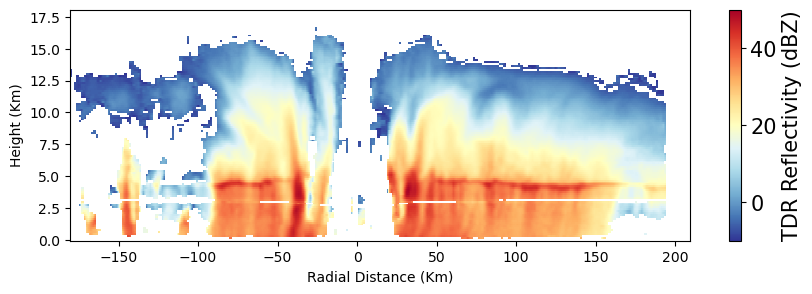

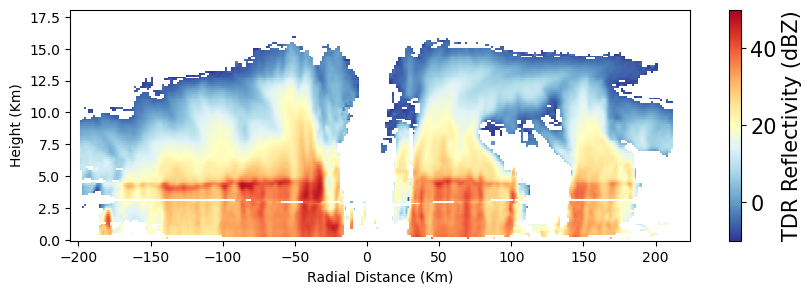

In [15]:
# check output! should have 3 tdr datasets. They all look great! yay!!
for i in range(len(tdr_new_reflect_list)):
    plt.figure(figsize=(10, 3))
    color_map = plt.cm.get_cmap( "RdYlBu").reversed()

    xaxis = tdr_new_dist_list[i]
    reflectivity = tdr_new_reflect_list[i]
    plt.pcolormesh( xaxis, tdr_data.height, reflectivity, cmap = color_map, vmin = -10, vmax = 50 )

    # making things prettier
    cbar = plt.colorbar( )
    cbar.ax.set_ylabel( ylabel="TDR Reflectivity (dBZ)", fontsize=15)
    cbar.ax.tick_params(labelsize=15)

    plt.ylabel( 'Height (Km)')
    plt.xlabel( 'Radial Distance (Km)')

    # plt.xlim([-207.0, 189.0])

In [85]:
# next step: figure out how to fill whitespace between interpolated tdr datasets

print('length of crl time axis = ' + str(len(crl_data.time.values)))
tdrsum = 0    
print('length of all tdr datasets = ' + str( tdrsum))

print(dist_maxs)
for i in range(len(dist_maxs)-1):
    print(dist_maxs[i+1] - dist_maxs[i])

    
# height for new arrays
tdrh = np.shape(tdr_new_reflect_list[0])[0]
    
# add whitespace to the total list! combine them here
total_matrix_list = []
for distmaxi, distmaxval in enumerate(dist_maxs):   
    
    print(distmaxi)
    
    # first value case: check for needed whitespace before the first tdr profile
    if distmaxi == 0:
        # whitespace is needed case
        if distmaxval > 0:
            # do i need to add one to distmaxval-0??
            add_array = np.empty(tdrh, distmaxval-0)            
            add_array[:] = np.nan
            total_matrix_list.append(add_array)
        # no matter what, add the first tdr profile to the list!
        total_matrix_list.append( tdr_new_reflect_list[0])
        
    # final value case: check for whitespace after last tdr profile
    elif distmaxi == len(dist_maxs) - 1:
        # whitespace is needed case
        if distmaxval < len(crl_data.time.values) - 1:
            # do i need to add one?
            add_array = np.full([tdrh, len(crl_data.time.values)-distmaxval], np.nan) 
            total_matrix_list.append(add_array)
        
    # odd integer cases (1, 3, etc): add whitespace between two tdr distances!
    elif distmaxi % 2 != 0:
        # find the width of the new array to be created
        width = dist_maxs[distmaxi+1] - distmaxval
        add_array = np.full([tdrh, width], np.nan)        
        total_matrix_list.append(add_array)
    
    # finally, look at the even integer cases: add actual tdr data to the matrix
    else:
        total_matrix_list.append( tdr_new_reflect_list[ int(distmaxi/2)])

length of crl time axis = 7322
length of all tdr datasets = 0
[0, 1815, 2460, 4105, 4704, 6727]
1815
645
1645
599
2023
0
1
2
3
4


IndexError: list index out of range

In [65]:
# combine all the tdr matrices in total_matrix_list!

total_matrix = []
for matrixi, matrixval in enumerate(total_matrix_list):
    if matrixi == 0:
        total_matrix=matrixval
    else:
        total_matrix = np.concatenate( (total_matrix, matrixval), axis=1)
    
print(np.shape(total_matrix))

(121, 6649)


'\nplt.pcolormesh( crl_data.time, crl_data.height, crl_data.T.transpose(), cmap = color_map, vmin=5, vmax=30 )\ncbar = plt.colorbar()\ncbar.ax.set_ylabel( ylabel="CRL Temperature ( C)", fontsize=20)\ncbar.ax.tick_params(labelsize=15)\nplt.ylabel( \'Height (m)\')\nax = plt.gca()\nax.set_facecolor(\'k\')\n'

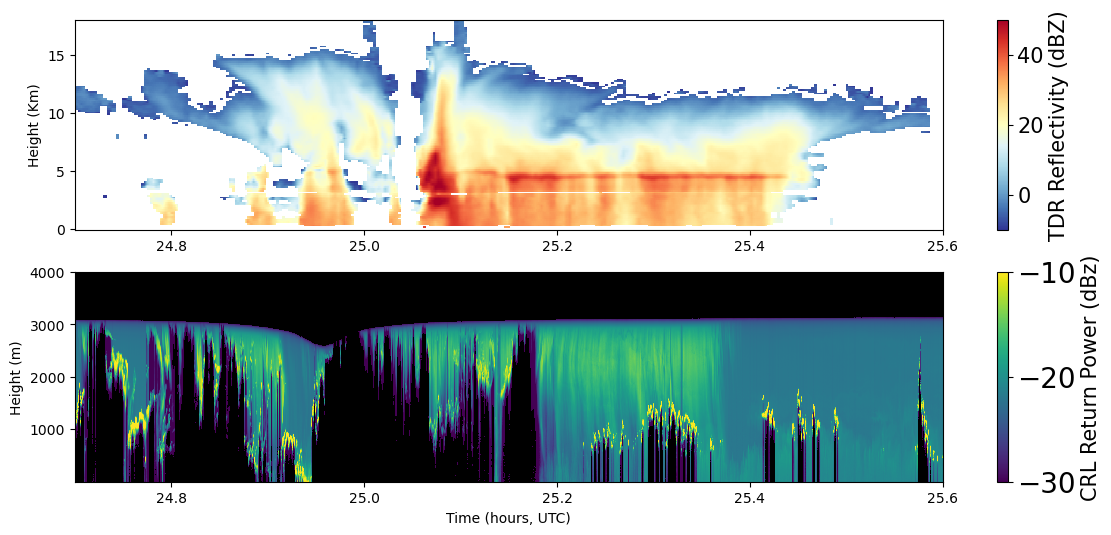

In [78]:
# make a figure checking out what the final, concatenated matrix looks like!
plt.figure(figsize=(14, 6))
color_map = plt.cm.get_cmap( "RdYlBu").reversed()

# 9/26 limits
# zoom = [24.7, 25.6] # [23.5, 24.3] # [22.3, 23.0]
zoom = False

plt.subplot(211)
reflectivity = total_matrix
plt.pcolormesh( crl_data.time, tdr_data.height, reflectivity, cmap = color_map, vmin = -10, vmax = 50 )
cbar = plt.colorbar( )
cbar.ax.set_ylabel( ylabel="TDR Reflectivity (dBZ)", fontsize=15)
cbar.ax.tick_params(labelsize=15)
plt.ylabel( 'Height (Km)')
if zoom:
    plt.xlim(zoom)

plt.subplot(212)
plt.pcolormesh(  crl_data.time, crl_data.height, crl_data.P_ch1.transpose(), vmin = -30, vmax =-10)    
plt.ylabel( 'Height (m)')    
cbar = plt.colorbar()
cbar.ax.set_ylabel( ylabel="CRL Return Power (dBz)", fontsize=15)
cbar.ax.tick_params(labelsize=20)
ax = plt.gca()
ax.set_facecolor('k')
if zoom:
    plt.xlim(zoom)

plt.xlabel( 'Time (hours, UTC)')

'''
plt.pcolormesh( crl_data.time, crl_data.height, crl_data.T.transpose(), cmap = color_map, vmin=5, vmax=30 )
cbar = plt.colorbar()
cbar.ax.set_ylabel( ylabel="CRL Temperature ( C)", fontsize=20)
cbar.ax.tick_params(labelsize=15)
plt.ylabel( 'Height (m)')
ax = plt.gca()
ax.set_facecolor('k')
'''
